In [1]:
import numpy as np
import pandas as pd
import math as mt
from matplotlib import pyplot as plt
from datetime import date
from sklearn import  linear_model
import tensorflow.compat.v1 as tf 
import seaborn as sns
%load_ext tensorboard

# Tarea 2 - Regresion Polinomial & Feature engineering

### Parte 1 - Modelo exponencial de covid-19 usando feature-eng

Usando el ejemplo de covid-19 en el notebook de feature-eng (https://colab.research.google.com/drive/1sJV2HG7tQgCGKES3-dIclzHQJ9qAWB3b?usp=sharing) crear un modelo de covid-19 para Guatemala.

* Convertir la fecha a un entero "número de día", por ejemplo si se usan datos desde el 22 de abril, este es el día 0, el 23 es el día 1.
* Aplicar regresión lineal sobre la variable "Confirmed" transformada.
* Una vez entrenado el modelo usarlo para aproximar la cantidad de casos confirmados para el 6 de Junio. Se debe reportar la cantidad de casos, no la cantidad transformada obtenida.

In [2]:
covid19_data = pd.read_csv('./covid_19_clean_complete.csv')
covid19_data["Date"] = pd.to_datetime(covid19_data["Date"],infer_datetime_format = True)
covid19_data.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0,0,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0,0,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0,0,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0,0,0


In [3]:
GT_confirmed = covid19_data[(covid19_data["Country/Region"] == 'Guatemala') & (covid19_data["Confirmed"] > 0)].copy()
GT_confirmed['Days'] = pd.to_datetime(GT_confirmed['Date']).sub(pd.Timestamp('2020-03-14')).dt.days
GT_confirmed.tail()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Days
31536,NaN,Guatemala,-29.609988,28.233608,2020-05-21,2397,0,0,68
31537,NaN,Guatemala,-29.609988,28.233608,2020-05-22,2644,0,0,69
31538,NaN,Guatemala,-29.609988,28.233608,2020-05-23,2875,0,0,70
31539,NaN,Guatemala,-29.609988,28.233608,2020-05-24,3186,0,0,71
31540,NaN,Guatemala,-29.609988,28.233608,2020-05-25,3556,0,0,72


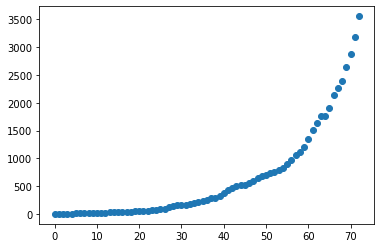

In [4]:
plt.scatter(GT_confirmed['Days'], GT_confirmed['Confirmed'])

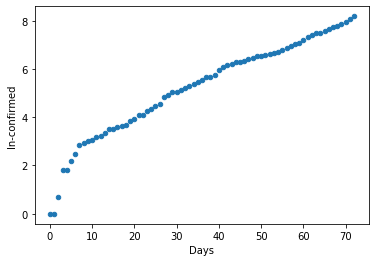

In [5]:
GT_confirmed["ln-confirmed"] = np.log(GT_confirmed["Confirmed"])
GT_confirmed.plot.scatter(x = "Days",y="ln-confirmed")

In [6]:
curve_fit = np.polyfit(GT_confirmed["Days"], GT_confirmed["ln-confirmed"], 1)
regresion = linear_model.LinearRegression()
regresion.fit(np.array(GT_confirmed["Days"]).reshape(-1,1),np.array( GT_confirmed["ln-confirmed"]).reshape(-1,1))
print(regresion.coef_)
print(regresion.intercept_)

[[0.09141241]]
[1.93160751]


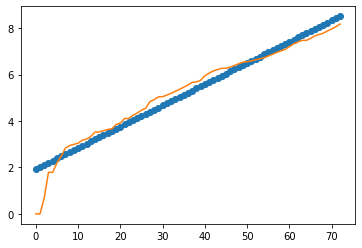

In [7]:
GT_confirmed["Predict-ln-confirmed"] = 1.9316 + 0.09141*GT_confirmed["Days"]
plt.plot(GT_confirmed["Days"], GT_confirmed["Predict-ln-confirmed"], "o")
plt.plot(GT_confirmed["Days"], GT_confirmed["ln-confirmed"])

In [8]:
PrediccionLN = 1.9316 + 0.09141*84
print(PrediccionLN)
Prediccion = mt.exp(PrediccionLN)
Prediccion


9.61004


14913.76662600675

# Mi modelo dio una predicion de 14913 casos para el dia 6 de Junio

### Parte 2 - Modelo polinomial de calidad de vinos

Es permitido utilizar [sklearn.preprocessing.polynomialfeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)


### Instrucciones

1. Seleccionar y transformar(generando las combinaciones polinomiales para un polinomio de grado dos o tres a elección) las features que considere que son las mejores para predecir la calidad del vino, utilizar como minimo 2 features. Para seleccionar las features, hacer un analisis exploratorio por ejemplo(pero no limitado a ):  graficando y viendo la forma en que se comportan los datos.

 Por ejemplo, se tienen las features "a" y "b" y seleccionamos polinomio de grado 2, hacemos feature engineering para obtener :
 
 $[a,b,a^{2},b^{2},ab]$
 
 No olvidar el "bias" (parámetro multiplicado por 1) ,con lo cual el dataset puede quedar con las columnas:
 
 $[1,a,b,a^{2},b^{2},ab]$
2. Una vez transformada la data aplicar regresion lineal con las features polinomiales usando Tensorflow.

Requisitos adicionales:
* Se debe agregar al notebook un screenshot del grafo de tensorboard, simplificando(usando  names , y name_scope como visto en clase).

* Se debe generar un directorio de logs de tensorboard para cada corrida/experimento , con cada directorio identificando facilmente la configuración del experimento como visto en clase, por ejemplo para un experimento con learning rate = 0.1 , y polinomio grado 2  crear un directorio: lr=0.1_polinomio_grado=2. (Agregar al notebook un screenshot de estas gráficas)

* Concluir en markdown cual es el mejor modelo para este caso basado en la comparativa entre curvas de costo/error en tensorboard.

In [9]:
dataVinos = pd.read_csv('winequality-red.csv')

### Red Wine Quality Data

Se aplicará regresión para crear un modelo de la calidad de vino en función de características del mismo, siendo 1 el peor vino y 10 el mejor.

Variables de entrada:
1. fixed acidity 
2. volatile acidity 
3. citric acid 
4. residual sugar 
5. chlorides 
6. free sulfur dioxide 
7. total sulfur dioxide 
8. density 
9. pH 
10. sulphates 
11. alcohol 

Varaible a predecir: 
12. quality (puntuacion  entre 0 y 10) 



In [22]:

tf.disable_eager_execution()
def multipleLinearModel(epochs, lr, data, ydata, strid):
    tf.reset_default_graph()
    m, n = data.shape
    xdata_mas_uno = np.c_[np.ones((m, 1)), data]
    X = tf.constant(xdata_mas_uno, dtype = tf.float32, name = 'X')
    Y = tf.constant(ydata.reshape(-1, 1), dtype = tf.float32, name = 'y')
    mb = tf.Variable(tf.random_uniform([n+1, 1], -1.0, 1.0), name = 'mb')
    yhat = tf.matmul(X, mb, name = 'yhat')
    error = 1/2*tf.reduce_mean(tf.square(tf.math.subtract(yhat , Y)), name = 'mse')
    grads = tf.gradients(error, mb)
    error_summary = tf.summary.scalar(name="MSE", tensor=error)
    newmb =  tf.subtract(mb ,tf.multiply(lr , grads[0] ))
    updatemb = tf.assign(mb, newmb)
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        writer = tf.summary.FileWriter(('.graphs/graphs_'+str(lr)+str(epochs)+strid), sess.graph)
        sess.run(init)
        for epoch in range(epochs):
            e_summary = sess.run(error_summary)
            if epoch % 10000 == 0:
                print('Epoch', epoch , 'MSE = ', error.eval())
            sess.run(updatemb)
            writer.add_summary(e_summary,epoch)
        print(mb.eval())

In [11]:
correlations = dataVinos.corr()['quality'].drop('quality')
print(correlations)

fixed acidity           0.124052
volatile acidity       -0.390558
citric acid             0.226373
residual sugar          0.013732
chlorides              -0.128907
free sulfur dioxide    -0.050656
total sulfur dioxide   -0.185100
density                -0.174919
pH                     -0.057731
sulphates               0.251397
alcohol                 0.476166
Name: quality, dtype: float64


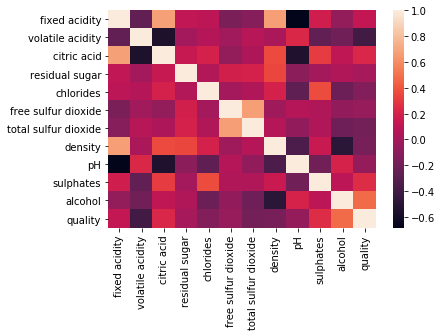

In [12]:
sns.heatmap(dataVinos.corr())
plt.show()

In [13]:
def obtenerFeatsAUsar(minimo):
    abs_corrs = correlations.abs()
    corr_altas = abs_corrs[abs_corrs > minimo].index.values.tolist()
    return corr_altas

# Unicamente utilizaremos las variables que tengan una correlacion mayor a 0.15

In [32]:
features = obtenerFeatsAUsar(0.35) 
x = dataVinos[features].copy() 
y = dataVinos['quality'].copy()
x['a2'] = x['volatile acidity'] * x['volatile acidity']
x['b2'] = x['alcohol'] * x['alcohol']
x['ab'] = x['volatile acidity'] * x['alcohol']
np.array(x)
np.array(y)
multipleLinearModel(100000,0.00004,np.array(x),np.array(y),'a2b2ab')


Epoch 0 MSE =  1029.5426
Epoch 10000 MSE =  0.52150047
Epoch 20000 MSE =  0.36513835
Epoch 30000 MSE =  0.2906574
Epoch 40000 MSE =  0.25517794
Epoch 50000 MSE =  0.23827581
Epoch 60000 MSE =  0.23022375
Epoch 70000 MSE =  0.22638634
Epoch 80000 MSE =  0.22455679
Epoch 90000 MSE =  0.22368442
[[ 0.27834302]
 [-0.6924668 ]
 [ 0.7850222 ]
 [ 0.56886965]
 [-0.01801348]
 [-0.12135362]]


In [33]:

multipleLinearModel(100000,0.00004,np.array(x)[:,0:4],np.array(y),'a2b2')

Epoch 0 MSE =  1731.3926
Epoch 10000 MSE =  0.40578008
Epoch 20000 MSE =  0.31630346
Epoch 30000 MSE =  0.28333473
Epoch 40000 MSE =  0.2701951
Epoch 50000 MSE =  0.26407275
Epoch 60000 MSE =  0.2604867
Epoch 70000 MSE =  0.25786802
Epoch 80000 MSE =  0.25567
Epoch 90000 MSE =  0.25368845
[[ 0.8247815 ]
 [-0.37131903]
 [ 0.56634694]
 [ 0.30720863]
 [-0.00905392]]


In [34]:

multipleLinearModel(100000,0.00004,np.array(x)[:,0:3],np.array(y),'a2')

Epoch 0 MSE =  1.4750288
Epoch 10000 MSE =  0.2862833
Epoch 20000 MSE =  0.28453472
Epoch 30000 MSE =  0.2828884
Epoch 40000 MSE =  0.28133723
Epoch 50000 MSE =  0.27987543
Epoch 60000 MSE =  0.2784899
Epoch 70000 MSE =  0.2771821
Epoch 80000 MSE =  0.2759404
Epoch 90000 MSE =  0.27477106
[[-0.26808384]
 [-0.5158454 ]
 [ 0.6138117 ]
 [-0.81517726]]


In [35]:

multipleLinearModel(100000,0.00004,np.array(x)[:,0:2],np.array(y),'lin')

Epoch 0 MSE =  99.70727
Epoch 10000 MSE =  0.26849288
Epoch 20000 MSE =  0.26817414
Epoch 30000 MSE =  0.26785764
Epoch 40000 MSE =  0.26754636
Epoch 50000 MSE =  0.26723656
Epoch 60000 MSE =  0.26692894
Epoch 70000 MSE =  0.2666264
Epoch 80000 MSE =  0.26632547
Epoch 90000 MSE =  0.2660266
[[-0.14781569]
 [-0.67769164]
 [ 0.58665127]]


# Tensorboard MSE scalar
![image info](./ScalarsMSE.png)

## Como podemos ver la grafica naranja es la que mas reduce el error la cual representa el modelo de grado 2

Y = a1 + a2*x + a3*z + a4*x^2 + a5*z^2 + a6*xz

Siendo X = Volatile Acidity
Siendo Z = Alcohol

# Con el siguiente resultado:

## Y = 0.27834302 - 0.6924668 x + 0.7850222 z + 0.56886965 x^2 -0.01801348 z^2 - 0.12135362 xz


# Grafo de TensorBoard
![image info](./grafo.png)